# TEAM C

**Main Purpose**: This notebook contains a model that is built to predict the CO2 emission of a vechile given some it features as input. It also contains an analysis of which features are the most important in predicting CO2 emission using Ordinary Least Square, Feature Permutation Analysis, F_Regression, Random Forest Feature Importance, CatBoost Model. The data used to train this model was scraped from https://www.car45.com, https://edmunds.com and https://fueleconomy.gov. The scraping algorithms can be found in the current folder where this notebook reside.

**Creator:** ***Muhammad Aliyu (TEAM C)***

**Date of Creation:** ***Saturday September 4, 2021***

**The Features used in building the model are:**
    Make, Model, Price, Engine Type, Transmission, Drive Type, Combined MPG, Total Seating, 
    Fuel Tank Capacity, Fuel Type, Base Engine Size, Horsepower, Torque, Turning Circle, 
    Front Head Room, Front Hip Room, Front Leg Room, Front Shoulder Room, Rear Head Room, 
    Rear Hip Room, Rear Leg Room, Rear Shoulder Room, Cargo Capacity All Seats In Place, 
    Curb Weight, EPA Interior Volume, Length, Overall Width Without Mirrors, Wheel Base

The number Zero in any of the features refer to a missing value

**Run the following scripts in the order they appear to scrape the data before running this notebook**
- car45.py
- car45-mpg-extractor
- edmunds-scaper

# Scraping Begins

**Scrape Data from https://www.car45.com**

**Features:** Make, Model, Year, Mileage (KM), Location, Transmission, Selling Condition, Colour, Price, Used Location

In [ ]:
!python car45.py

**Scrape Data from https://fueleconomy.gov**

**Features:** MPG

In [ ]:
!python car45-mpg-extractor.py

**Scrape Data from https://edmunds.com**

**Features:** Make, Model, Engine Type, Transmission, Drive Type, Combined MPG, Total Seating, 
    Fuel Tank Capacity, Fuel Type, Base Engine Size, Horsepower, Torque, Turning Circle, 
    Front Head Room, Front Hip Room, Front Leg Room, Front Shoulder Room, Rear Head Room, 
    Rear Hip Room, Rear Leg Room, Rear Shoulder Room, Cargo Capacity, All Seats In Place, 
    Curb Weight, EPA Interior Volume, Length, Overall Width Without Mirrors, Wheel Base

In [ ]:
!python edmunds-scaper.py

# Model Building and Analysis Begins

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, LinearRegression
import seaborn as sns
import scipy.stats as stats

In [2]:
rand_state = 0

In [3]:
car45_with_edmunds = pd.read_csv("car45_with_edmunds.csv")
car45 = pd.read_csv("car45.csv")
car45_with_mpg = pd.read_csv("car45_with_mpg.csv")["MPG"]

In [4]:
col = ["Make", "Model", "Year", "Transmission", "Selling Condition", "Colour", "Unnamed: 0", "Used Location"]
car45 = car45.drop(col, axis=1)

In [5]:
car45.tail()

,Mileage (KM),Location,Price
5213,143191.0,"C45, Abuja",930000
5214,49844.0,"C45, Port",1390000
5215,1249000.0,"C45, Owerri",2080000
5216,186104.0,"C45, Port",6910000
5217,121345.0,"C45, Lagos",9500000


In [6]:
col2 = ["Make", "Model", "Transmission", "Unnamed: 0", "Drive Type", "Engine Type"]
car45_with_edmunds = car45_with_edmunds.drop(col2, axis=1)

In [7]:
car45_with_edmunds.tail()

,Combined MPG,Total Seating,Fuel Tank Capacity,Fuel Type,Base Engine Size,Horsepower,Torque,Turning Circle,Front Head Room,Front Hip Room,...,Rear Head Room,Rear Hip Room,Rear Leg Room,Rear Shoulder Room,"Cargo Capacity, All Seats In Place",Curb Weight,EPA Interior Volume,Length,Overall Width Without Mirrors,Wheel Base
5213,30,5,14.5,Regular unleaded,2.5,181,181,35.4,41.1,54.1,...,39.2,53.4,38.5,55.9,31.6,3371,137.0,183.0,72.4,106.5
5214,25,5,21.1,Premium unleaded (required),3.0,362,369,39.0,36.9,58.9,...,35.9,58.6,35.0,56.5,11.9,0,0.0,196.4,73.9,115.7
5215,23,5,20.0,Premium unleaded (required),3.0,300,295,36.7,39.5,53.2,...,36.8,52.5,35.1,56.1,13.5,3732,0.0,189.6,71.8,112.2
5216,32,5,15.8,Regular unleaded,1.5,160,184,37.0,39.1,54.1,...,37.5,53.4,38.1,57.1,15.7,3135,0.0,194.2,73.0,111.4
5217,0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [8]:
df = pd.concat([car45, car45_with_edmunds, car45_with_mpg], axis=1)

In [9]:
len(df)

5218

In [10]:
df.tail()

,Mileage (KM),Location,Price,Combined MPG,Total Seating,Fuel Tank Capacity,Fuel Type,Base Engine Size,Horsepower,Torque,...,Rear Hip Room,Rear Leg Room,Rear Shoulder Room,"Cargo Capacity, All Seats In Place",Curb Weight,EPA Interior Volume,Length,Overall Width Without Mirrors,Wheel Base,MPG
5213,143191.0,"C45, Abuja",930000,30,5,14.5,Regular unleaded,2.5,181,181,...,53.4,38.5,55.9,31.6,3371,137.0,183.0,72.4,106.5,18
5214,49844.0,"C45, Port",1390000,25,5,21.1,Premium unleaded (required),3.0,362,369,...,58.6,35.0,56.5,11.9,0,0.0,196.4,73.9,115.7,16
5215,1249000.0,"C45, Owerri",2080000,23,5,20.0,Premium unleaded (required),3.0,300,295,...,52.5,35.1,56.1,13.5,3732,0.0,189.6,71.8,112.2,0
5216,186104.0,"C45, Port",6910000,32,5,15.8,Regular unleaded,1.5,160,184,...,53.4,38.1,57.1,15.7,3135,0.0,194.2,73.0,111.4,18
5217,121345.0,"C45, Lagos",9500000,0,0,0.0,0,0.0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0


In [11]:
df.columns

Index(['Mileage (KM)', 'Location', 'Price', 'Combined MPG', 'Total Seating',
       'Fuel Tank Capacity', 'Fuel Type', 'Base Engine Size', 'Horsepower',
       'Torque', 'Turning Circle', 'Front Head Room', 'Front Hip Room',
       'Front Leg Room', 'Front Shoulder Room', 'Rear Head Room',
       'Rear Hip Room', 'Rear Leg Room', 'Rear Shoulder Room',
       'Cargo Capacity, All Seats In Place', 'Curb Weight',
       'EPA Interior Volume', 'Length', 'Overall Width Without Mirrors',
       'Wheel Base', 'MPG'],
      dtype='object')

# CO2 Emission Calculation from some features

In [12]:
df['kg_for_co2'] = df['Fuel Type'].apply(lambda x: 2.31 if x == "Regular unleaded" else 2.61)
df["CO2 emission(kg)"] = (df["Mileage (KM)"]*3.785411784*df.kg_for_co2)/df["Combined MPG"]
base_engine_size = []
for i in range(len(df)):
    # Petrol
    if df["Base Engine Size"].iloc[i] <= 1.4 and df['kg_for_co2'].iloc[i] == 2.31:
        base_engine_size.append(0.17)
    elif df["Base Engine Size"].iloc[i] > 1.4 and df["Base Engine Size"].iloc[i] <= 2.1 and df['kg_for_co2'].iloc[i] == 2.31:
        base_engine_size.append(0.22)
    elif df["Base Engine Size"].iloc[i] > 2.1 and df['kg_for_co2'].iloc[i] == 2.31:
        base_engine_size.append(0.27)
    # Diesel
    if df["Base Engine Size"].iloc[i] <= 2 and df['kg_for_co2'].iloc[i] == 2.61:
        base_engine_size.append(0.12)
    elif df["Base Engine Size"].iloc[i] > 2 and df['kg_for_co2'].iloc[i] == 2.61:
        base_engine_size.append(0.14)
df["Q"] = base_engine_size
df["CO2 emission(g/km)"] = np.round(df["CO2 emission(kg)"] * 1000 * df["Q"])

# Cars Features For Different States in Nigeria

In [13]:
# Remove all rows where values are equal 0
df = df[(df != 0).all(axis=1)]

In [14]:
def Calculation(name):
    location = df.groupby("Location")[name].mean()
    location = np.round(location).sort_values()
    location.plot(kind='bar', title=name, ylabel='{0} {1}'.format('Mean', name), xlabel='Location', figsize=(10, 5))

**CO2 Emissions By States**

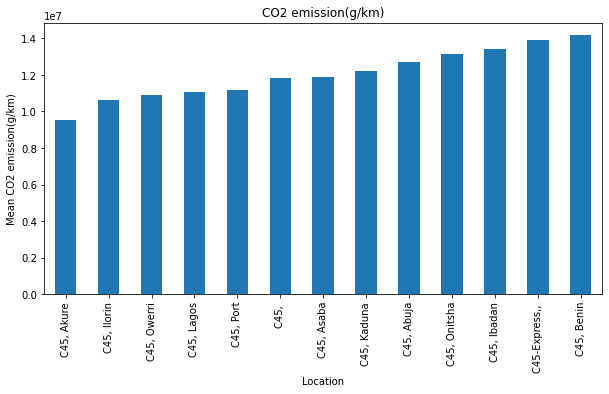

In [15]:
Calculation("CO2 emission(g/km)")

**States with the most expensive cars**

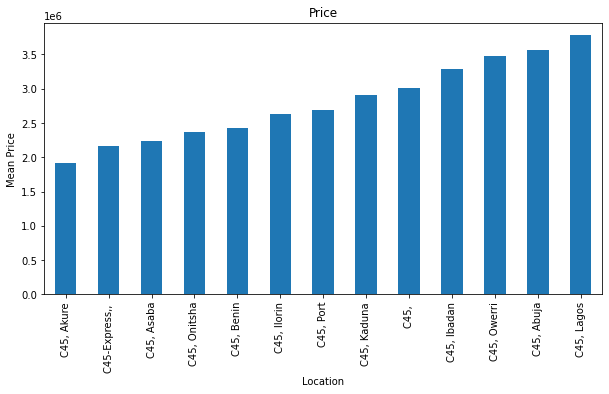

In [16]:
Calculation("Price")

**States the most mileages cars**

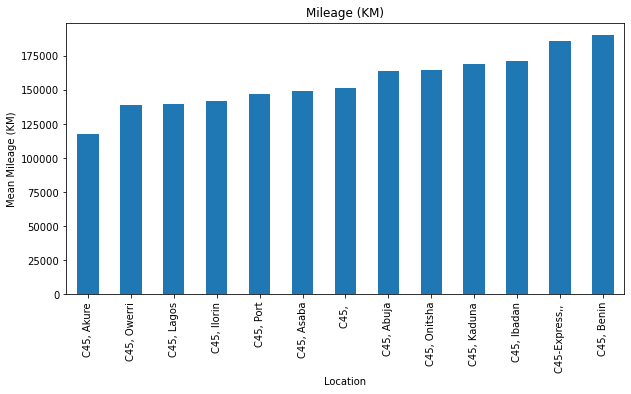

In [17]:
Calculation("Mileage (KM)")

**States with cars that have more Curb Weight**

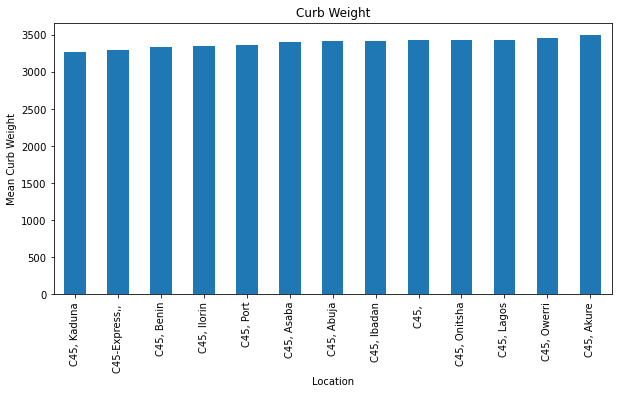

In [18]:
Calculation("Curb Weight")

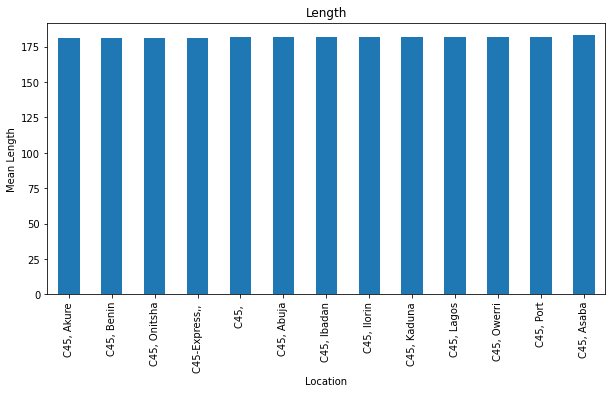

In [19]:
Calculation("Length")

**States with cars with the most Cargo Capacity cars**

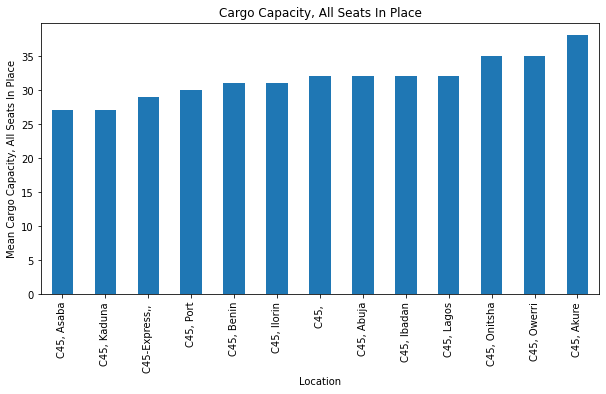

In [20]:
Calculation("Cargo Capacity, All Seats In Place")

In [21]:
df = df.drop(["Location"], axis=1)

In [22]:
df.tail()

,Mileage (KM),Price,Combined MPG,Total Seating,Fuel Tank Capacity,Fuel Type,Base Engine Size,Horsepower,Torque,Turning Circle,...,Curb Weight,EPA Interior Volume,Length,Overall Width Without Mirrors,Wheel Base,MPG,kg_for_co2,CO2 emission(kg),Q,CO2 emission(g/km)
5186,155341.0,2310000,29,5,14.5,Regular unleaded,2.5,203,184,36.1,...,3490,136.4,180.9,73.0,105.9,20,2.31,46839.603310,0.27,12646693.0
5188,126078.0,5472500,29,5,14.5,Regular unleaded,2.5,203,184,36.1,...,3490,136.4,180.9,73.0,105.9,36,2.31,38016.000322,0.27,10264320.0
5205,59335.0,5185000,26,7,17.7,Regular unleaded,2.5,191,181,37.9,...,3794,121.3,189.0,74.8,110.8,42,2.31,19955.504344,0.27,5387986.0
5207,66866.0,3345000,29,5,14.5,Regular unleaded,2.5,203,184,36.1,...,3490,136.4,180.9,73.0,105.9,17,2.31,20161.946395,0.27,5443726.0
5213,143191.0,930000,30,5,14.5,Regular unleaded,2.5,181,181,35.4,...,3371,137.0,183.0,72.4,106.5,18,2.31,41736.841205,0.27,11268947.0


In [23]:
features = ["Fuel Type", "CO2 emission(kg)", "kg_for_co2", "Q", "Combined MPG"]
df = df.drop(features, axis=1)

In [24]:
len(df)

1749

In [25]:
# dropping duplicate rows
df.drop_duplicates(inplace=True)

In [26]:
len(df)

1746

In [27]:
df = df.sample(frac=1, random_state=rand_state).reset_index(drop=True)

# Visualization of some features and Check for Rare Values

In [28]:
def discrete_info(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments
    
    # inspect unique values
    print(df[variable].unique())
    print("Total:", df[variable].nunique())
    
    # count each discrete occurrance
    print(df[variable].value_counts())
    
    # count null occurrance
    print("Null Count:", df[variable].isnull().sum())

    # define figure size
    plt.figure(figsize=(16, 4))
    
    # histogram
    plt.subplot(1, 4, 1)
    sns.histplot(df[variable], bins=20)
    plt.title(f'{variable} Histogram')

    # Q-Q plot
    plt.subplot(1, 4, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel(f'{variable} Quantiles')

    # boxplot
    plt.subplot(1, 4, 3)
    sns.boxplot(y=df[variable])
    plt.title(f'{variable} Boxplot')
    
    # kde
    plt.subplot(1, 4, 4)
    sns.kdeplot(x=df[variable])
    plt.title(f'{variable} KDE')

    plt.show()

In [29]:
def categorical_info(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments
    
    # inspect unique values
    print(df[variable].unique())
    print("Total:", df[variable].nunique())
    
    # count each categorical occurrance
    print(df[variable].value_counts())
    
    # count null occurrance
    print("Null Count:", df[variable].isnull().sum())

    # define figure size
    plt.figure(figsize=(16, 4))

    # histograms of discrete variables often show
    # a bar plot shape, instead of continuous intervals
    # df[variable].hist(bins=20)
    
    # now let's calculate the frequency for each category
    label_freq = df[variable].value_counts() / len(df)

    # let's make plot with the category frequencies
    fig = label_freq.sort_values(ascending=False).plot.bar()

    # add a line to signal 5 % frequency limit
    # under which we will consider a category as rare
    fig.axhline(y=0.05, color='red')

    # add axis labels and title
    fig.set_ylabel('percentage within each category')
    fig.set_xlabel('Variable: class')
    fig.set_title('Identifying Rare Categories')
    plt.show()

[19469627.  6058308. 12367660. ...  9376637. 10634819.  9965181.]
Total: 1730
17488544.0    7
81.0          3
24423656.0    3
8141165.0     2
15961727.0    2
             ..
13676072.0    1
5232435.0     1
9023106.0     1
10268309.0    1
2011213.0     1
Name: CO2 emission(g/km), Length: 1730, dtype: int64
Null Count: 0


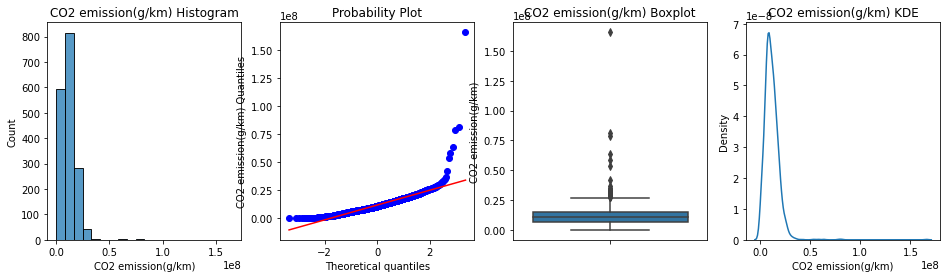

In [30]:
discrete_info(df, "CO2 emission(g/km)")

[239148.  74415. 157152. ... 119146. 182430. 170943.]
Total: 1724
299999.0    10
1.0          4
999999.0     3
113100.0     2
199111.0     2
            ..
99688.0      1
135330.0     1
146091.0     1
146314.0     1
184320.0     1
Name: Mileage (KM), Length: 1724, dtype: int64
Null Count: 0


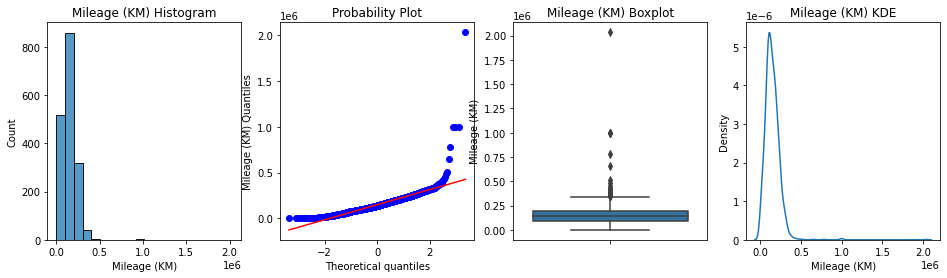

In [31]:
discrete_info(df, "Mileage (KM)")

[180.9 183.  182.3 192.8 189.  172.6 189.8 198.4 179.1 192.1 182.1 167.9
 185.4 191.3 196.5 173.4 167.6 190.5]
Total: 18
180.9    1202
182.3     245
183.0     113
189.0      67
172.6      47
192.8      33
189.8      18
167.9       7
198.4       4
192.1       2
190.5       1
185.4       1
191.3       1
182.1       1
167.6       1
196.5       1
173.4       1
179.1       1
Name: Length, dtype: int64
Null Count: 0


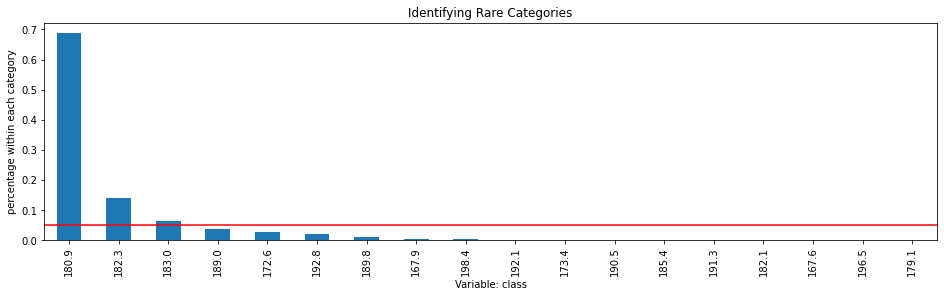

In [32]:
categorical_info(df, "Length")

[203 181 139 300 191 120 293 292 260 187 182 275 241 280 177 155]
Total: 16
203    1204
139     245
181     113
191      67
120      47
300      19
293      18
260      14
275       7
292       4
280       2
182       2
241       1
187       1
177       1
155       1
Name: Horsepower, dtype: int64
Null Count: 0


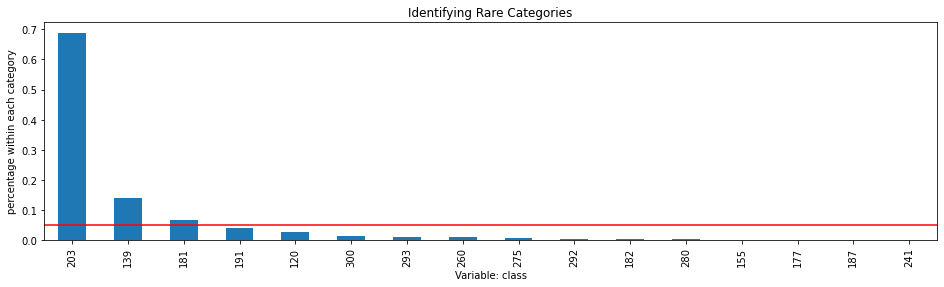

In [33]:
categorical_info(df, "Horsepower")

[3490 3371 2910 3612 3794 2767 4746 3957 3833 3691 3310 3541 3106 3715
 3637 4041 3184 3124 4215]
Total: 19
3490    1202
2910     245
3371     113
3794      67
2767      47
3612      19
4746      18
3833      14
3106       7
3957       4
3310       2
3124       1
4041       1
3184       1
3541       1
3637       1
3691       1
3715       1
4215       1
Name: Curb Weight, dtype: int64
Null Count: 0


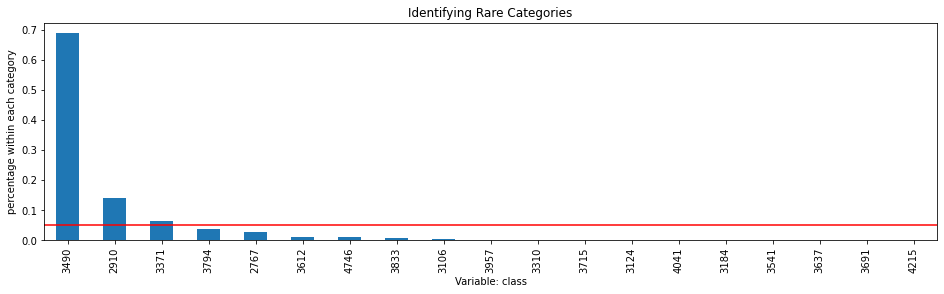

In [34]:
categorical_info(df, "Curb Weight")

# Remove some features that are highly correlated with other features and also remove unnecessary features

***Rear Hip Room*** and ***Front Leg Room*** has strong a negative correlation with ***Cargo Capacity All Seats In Place***

***Torque***, ***Horsepower*** and ***Fuel Tank Capacity*** has a strong positive correlation with ***Curb Weight***

***Front Hip Room*** has a strong positive correlation with ***Total Seating***

***EPA Interior Volume*** has a strong positive correlation with ***Overall Width Without Mirrors***

***Front Shoulder Room*** has a strong positive correlation with ***Overall Width Without Mirrors***

***Rear Shoulder Room*** and ***Overall Width Without Mirrors*** has a strong positive correlation with ***Curb Weight***

***Front Head Room*** and ***Front Leg Room*** has strong a negative correlation with ***Cargo Capacity All Seats In Place***

***Total Seating*** and ***Wheel Base*** has a strong positive correlation with ***Length***

In [35]:
df.corr()

,Mileage (KM),Price,Total Seating,Fuel Tank Capacity,Base Engine Size,Horsepower,Torque,Turning Circle,Front Head Room,Front Hip Room,...,Rear Leg Room,Rear Shoulder Room,"Cargo Capacity, All Seats In Place",Curb Weight,EPA Interior Volume,Length,Overall Width Without Mirrors,Wheel Base,MPG,CO2 emission(g/km)
Mileage (KM),1.000000,-0.322803,-0.040279,-0.005485,0.017855,0.007722,0.004060,0.011745,-0.000785,0.004821,...,0.004200,-0.013035,0.031529,0.002405,0.021891,0.030364,0.015901,0.010474,-0.033883,0.973185
Price,-0.322803,1.000000,-0.043367,-0.000849,0.042434,0.080189,0.063114,0.032026,-0.048741,0.029927,...,0.038867,0.068327,0.129350,0.072849,0.095636,-0.053896,0.080039,-0.024664,-0.052465,-0.302294
Total Seating,-0.040279,-0.043367,1.000000,0.428489,0.076959,-0.026362,0.016059,0.488929,0.277946,0.533598,...,0.549109,0.282585,-0.362667,0.285933,-0.095901,0.519950,0.331558,0.524655,0.207652,0.008185
Fuel Tank Capacity,-0.005485,-0.000849,0.428489,1.000000,0.778824,0.705398,0.718471,0.734831,0.426850,0.900200,...,0.582038,0.603848,0.133233,0.851085,0.350522,0.733043,0.767783,0.856076,-0.166984,0.127855
Base Engine Size,0.017855,0.042434,0.076959,0.778824,1.000000,0.945292,0.951715,0.669483,0.606807,0.685788,...,0.659648,0.848696,0.612868,0.912814,0.763285,0.508831,0.897569,0.541059,-0.351569,0.179283
Horsepower,0.007722,0.080189,-0.026362,0.705398,0.945292,1.000000,0.984951,0.691748,0.439461,0.623898,...,0.547931,0.803732,0.629456,0.871871,0.723896,0.356389,0.854751,0.446217,-0.342477,0.154716
Torque,0.004060,0.063114,0.016059,0.718471,0.951715,0.984951,1.000000,0.680434,0.560479,0.634398,...,0.612574,0.834293,0.620053,0.882508,0.750785,0.372213,0.870833,0.463079,-0.358258,0.157254
Turning Circle,0.011745,0.032026,0.488929,0.734831,0.669483,0.691748,0.680434,1.000000,0.218855,0.801224,...,0.590393,0.561678,0.106296,0.680369,0.293298,0.713070,0.772054,0.749543,-0.078936,0.110712
Front Head Room,-0.000785,-0.048741,0.277946,0.426850,0.606807,0.439461,0.560479,0.218855,1.000000,0.356574,...,0.765791,0.726304,0.465091,0.606993,0.694175,0.242643,0.613793,0.226175,-0.270034,0.133827
Front Hip Room,0.004821,0.029927,0.533598,0.900200,0.685788,0.623898,0.634398,0.801224,0.356574,1.000000,...,0.698040,0.621982,0.163462,0.824686,0.383617,0.712562,0.820336,0.859571,-0.125303,0.144879


In [36]:
column = ["Front Hip Room", "Torque", "Front Shoulder Room", "Rear Shoulder Room", "Rear Head Room", 
          "Front Shoulder Room", "Rear Leg Room", "Turning Circle",
          "Rear Hip Room", "Front Head Room", "Front Leg Room"]
df = df.drop(column, axis=1)

In [37]:
df.corr()

,Mileage (KM),Price,Total Seating,Fuel Tank Capacity,Base Engine Size,Horsepower,"Cargo Capacity, All Seats In Place",Curb Weight,EPA Interior Volume,Length,Overall Width Without Mirrors,Wheel Base,MPG,CO2 emission(g/km)
Mileage (KM),1.000000,-0.322803,-0.040279,-0.005485,0.017855,0.007722,0.031529,0.002405,0.021891,0.030364,0.015901,0.010474,-0.033883,0.973185
Price,-0.322803,1.000000,-0.043367,-0.000849,0.042434,0.080189,0.129350,0.072849,0.095636,-0.053896,0.080039,-0.024664,-0.052465,-0.302294
Total Seating,-0.040279,-0.043367,1.000000,0.428489,0.076959,-0.026362,-0.362667,0.285933,-0.095901,0.519950,0.331558,0.524655,0.207652,0.008185
Fuel Tank Capacity,-0.005485,-0.000849,0.428489,1.000000,0.778824,0.705398,0.133233,0.851085,0.350522,0.733043,0.767783,0.856076,-0.166984,0.127855
Base Engine Size,0.017855,0.042434,0.076959,0.778824,1.000000,0.945292,0.612868,0.912814,0.763285,0.508831,0.897569,0.541059,-0.351569,0.179283
Horsepower,0.007722,0.080189,-0.026362,0.705398,0.945292,1.000000,0.629456,0.871871,0.723896,0.356389,0.854751,0.446217,-0.342477,0.154716
"Cargo Capacity, All Seats In Place",0.031529,0.129350,-0.362667,0.133233,0.612868,0.629456,1.000000,0.598503,0.940006,-0.240405,0.617062,-0.186571,-0.372636,0.173776
Curb Weight,0.002405,0.072849,0.285933,0.851085,0.912814,0.871871,0.598503,1.000000,0.764783,0.456292,0.960233,0.593198,-0.291116,0.186446
EPA Interior Volume,0.021891,0.095636,-0.095901,0.350522,0.763285,0.723896,0.940006,0.764783,1.000000,-0.009305,0.793230,0.038614,-0.380547,0.194021
Length,0.030364,-0.053896,0.519950,0.733043,0.508831,0.356389,-0.240405,0.456292,-0.009305,1.000000,0.495641,0.912663,-0.024250,0.078810


<AxesSubplot:xlabel='Price', ylabel='CO2 emission(g/km)'>

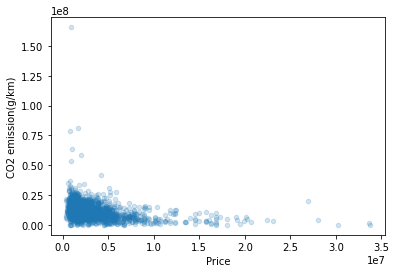

In [38]:
df.plot(x="Price", y='CO2 emission(g/km)', kind='scatter', alpha=0.2)

In [39]:
trainy = df["CO2 emission(g/km)"]
train = df.drop(["CO2 emission(g/km)"], axis=1)

In [40]:
trainy

0       19469627.0
1        6058308.0
2       12367660.0
3        7063752.0
4       26372915.0
           ...    
1741     6468057.0
1742    14773838.0
1743     9376637.0
1744    10634819.0
1745     9965181.0
Name: CO2 emission(g/km), Length: 1746, dtype: float64

In [41]:
len(train)

1746

In [42]:
train.head()

,Mileage (KM),Price,Total Seating,Fuel Tank Capacity,Base Engine Size,Horsepower,"Cargo Capacity, All Seats In Place",Curb Weight,EPA Interior Volume,Length,Overall Width Without Mirrors,Wheel Base,MPG
0,239148.0,3146000,5,14.5,2.5,203,37.5,3490,136.4,180.9,73.0,105.9,20
1,74415.0,2698000,5,14.5,2.5,203,37.5,3490,136.4,180.9,73.0,105.9,26
2,157152.0,2362000,5,14.5,2.5,181,31.6,3371,137.0,183.0,72.4,106.5,28
3,86765.0,2026000,5,14.5,2.5,203,37.5,3490,136.4,180.9,73.0,105.9,14
4,323942.0,2495000,5,14.5,2.5,203,37.5,3490,136.4,180.9,73.0,105.9,26


In [43]:
X_train, X_test, y_train, y_test = train_test_split(train, trainy, test_size=0.25, random_state=rand_state)

# Random Forest Feature Importance Analysis

157596.65315789467


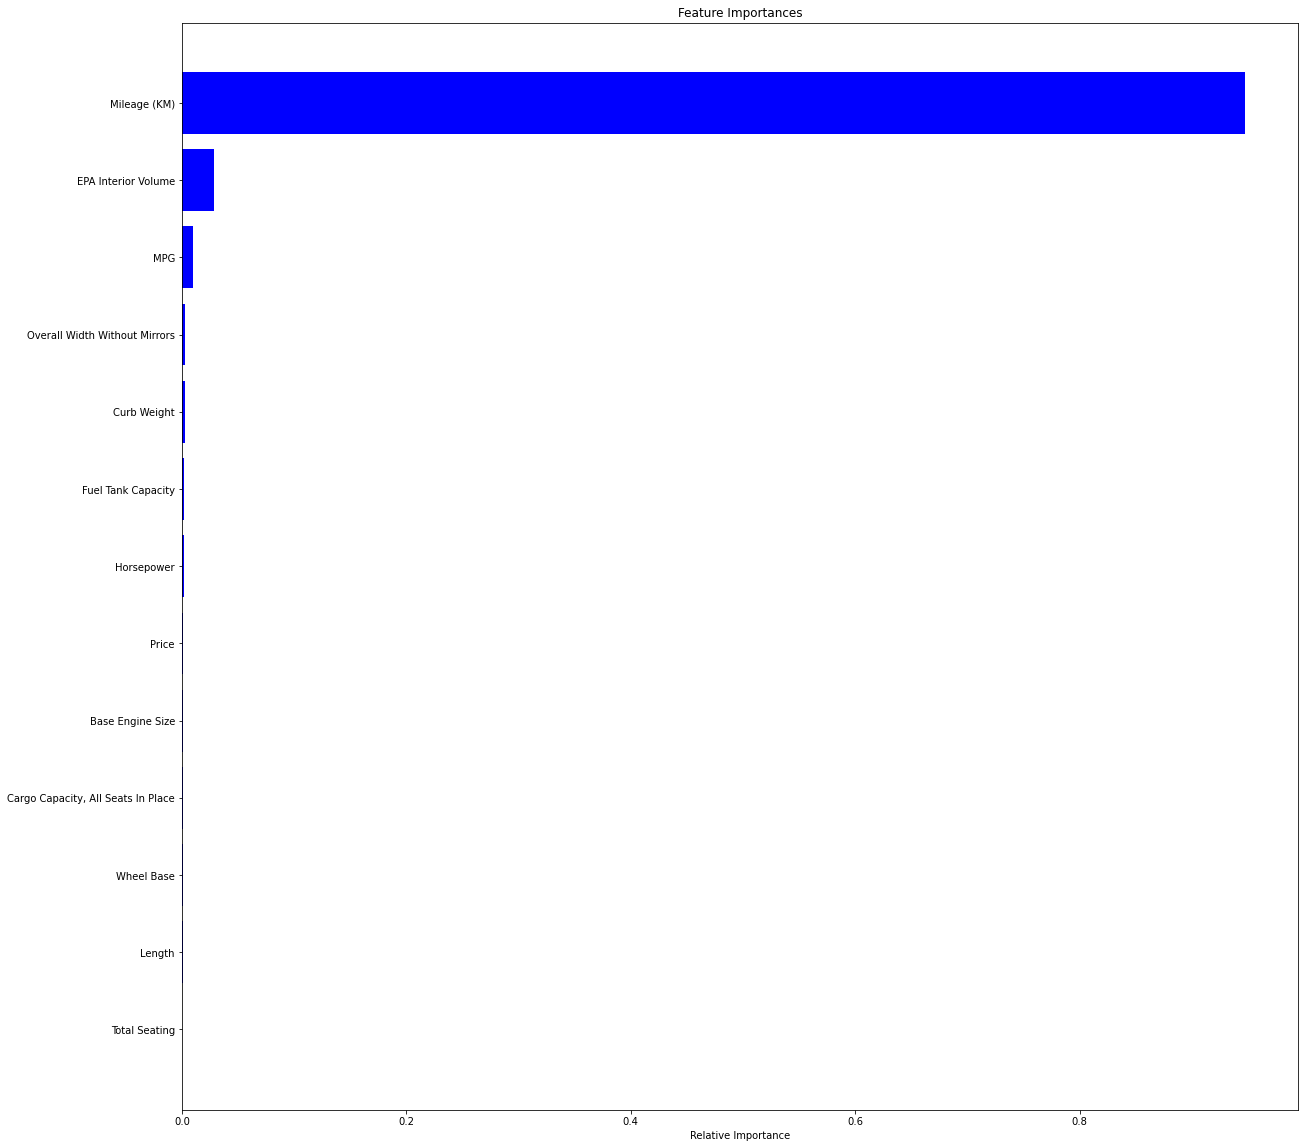

In [44]:
model = RandomForestRegressor(random_state=rand_state).fit(X_train, y_train)
#validation set prediction
predictions = model.predict(X_test)
print(mean_absolute_error(y_test, predictions))

features = train.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=[20, 20])
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# OLS Analysis and Permutation Analysis

In [45]:
# OLS Analysis
model = LinearRegression().fit(X_train, y_train)
model.score(X_test, y_test)
print("\tOLS Coefficients for each feature\n")
for i in np.abs(model.coef_).argsort()[::-1]:
    print(list(train.columns)[i], np.abs(model.coef_[i]))

print("\n\tPermutation Analysis\n")
r = permutation_importance(model, X_test, y_test,
                           n_repeats=30,
                           random_state=rand_state)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{list(train.columns)[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

	OLS Coefficients for each feature

Base Engine Size 3841071.687353597
Total Seating 1978286.1921047417
Fuel Tank Capacity 746791.2664717275
Wheel Base 746218.1827182976
Length 452085.00587412156
Overall Width Without Mirrors 237669.89240497092
Cargo Capacity, All Seats In Place 150361.28937305434
Horsepower 25906.774557520872
EPA Interior Volume 14343.685702405039
Curb Weight 6262.603222218853
MPG 887.7683159494698
Mileage (KM) 78.98205077021221
Price 0.0008846378232389149

	Permutation Analysis

Mileage (KM) 1.945  +/- 0.095
Curb Weight 0.123  +/- 0.005
Cargo Capacity, All Seats In Place 0.091  +/- 0.005
Length   0.075  +/- 0.003
Base Engine Size 0.061  +/- 0.003
Wheel Base 0.061  +/- 0.004
Fuel Tank Capacity 0.040  +/- 0.003
Horsepower 0.024  +/- 0.002
Total Seating 0.024  +/- 0.002
Overall Width Without Mirrors 0.004  +/- 0.001
EPA Interior Volume 0.001  +/- 0.000


In [46]:
import statsmodels.api as sm
model = sm.OLS(y_train, X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     CO2 emission(g/km)   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          2.783e+04
Date:                Sun, 05 Sep 2021   Prob (F-statistic):                        0.00
Time:                        18:42:13   Log-Likelihood:                         -19721.
No. Observations:                1309   AIC:                                  3.947e+04
Df Residuals:                    1296   BIC:                                  3.954e+04
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Mileage (KM)                          79.0422      0.254    310.913      0.000      78.543      79.541
Price                                  0.0005      0.008      0.067      0.946      -0.014       0.015
Total Seating                       3.303e+06   3.89e+05      8.498      0.000    2.54e+06    4.07e+06
Fuel Tank Capacity                  1.113e+06   1.77e+05      6.274      0.000    7.65e+05    1.46e+06
Base Engine Size                     3.73e+06   6.02e+05      6.200      0.000    2.55e+06    4.91e+06
Horsepower                         -1.155e+04   5927.106     -1.948      0.052   -2.32e+04      79.225
Cargo Capacity, All Seats In Place  2.401e+05   3.45e+04      6.952      0.000    1.72e+05    3.08e+05
Curb Weight                        -9167.8035   1763.842     -5.198      0.000   -1.26e+04   -5707.506
EPA Interior Volume                 1.749e+04   1.35e+04      1.298      0.194   -8941.091    4.39e+04
Length                             -4.734e+05   3.86e+04    -12.263      0.000   -5.49e+05   -3.98e+05
Overall Width Without Mirrors      -3.937e+05   1.22e+05     -3.236      0.001   -6.32e+05   -1.55e+05
Wheel Base                          9.037e+05   9.25e+04      9.772      0.000    7.22e+05    1.09e+06
MPG                                  188.5857   2911.502      0.065      0.948   -5523.187    5900.358
==============================================================================
Omnibus:                      337.093   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7607.541
Skew:                          -0.634   Prob(JB):                         0.00
Kurtosis:                      14.742   Cond. No.                     1.26e+08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.26e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Normal Test

In [47]:
arr_null_hyp = []
k2, p = stats.normaltest(df)
alpha = 1e-3
feature_columns = list(df.columns)
for i in range(len(list(feature_columns))):
    if p[i] < alpha:  # null hypothesis: feature comes from a normal distribution
        arr_null_hyp.append("rejected")
    else:
        arr_null_hyp.append("accepted")
pd.DataFrame(np.c_[feature_columns, k2, p, arr_null_hyp], columns=["Features", "k2", "P", "Null Hypothesis"])

,Features,k2,P,Null Hypothesis
0,Mileage (KM),2129.7248251544343,0.0,rejected
1,Price,1403.2558357943628,1.935828627343996e-305,rejected
2,Total Seating,1596.5475415612348,0.0,rejected
3,Fuel Tank Capacity,1391.5980479800523,6.581476993000835e-303,rejected
4,Base Engine Size,128.20395496934992,1.4483212385101378e-28,rejected
5,Horsepower,108.7263423512914,2.456827924311913e-24,rejected
6,"Cargo Capacity, All Seats In Place",300.49835044679884,5.592581090861781e-66,rejected
7,Curb Weight,200.54733226336037,2.8294375888714823e-44,rejected
8,EPA Interior Volume,371.8399786698707,1.8029121119523605e-81,rejected
9,Length,468.7866776860261,1.600539311886702e-102,rejected


# f_regression Analysis

Mileage (KM): 24973.982071
Price: 118.725062
Total Seating: 0.704579
Fuel Tank Capacity: 20.433126
Base Engine Size: 39.375158
Horsepower: 26.144392
Cargo Capacity, All Seats In Place: 35.805625
Curb Weight: 43.572520
EPA Interior Volume: 47.419674
Length: 8.577803
Overall Width Without Mirrors: 48.688497
Wheel Base: 10.197009
MPG: 6.736827


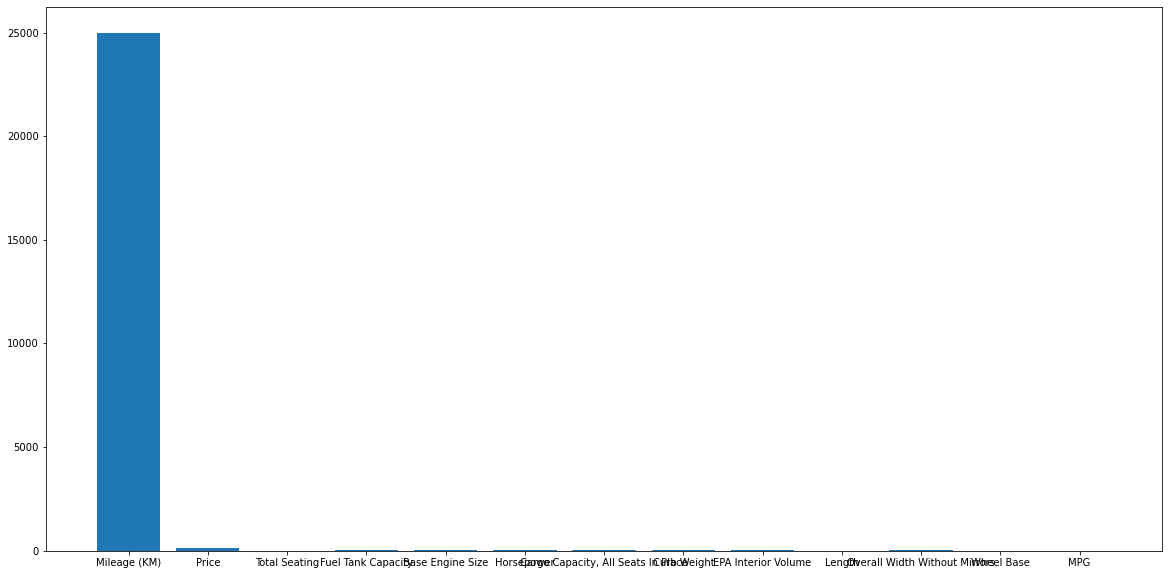

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot

# feature selection with f_regression
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('%s: %f' % (list(train.columns)[i], fs.scores_[i]))
# plot the scores
pyplot.figure(figsize=[20, 10])
pyplot.bar([list(train.columns)[i] for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

# CatBoost Model and Feature Importance Analysis

In [49]:
model = CatBoostRegressor(n_estimators=200000, grow_policy="Lossguide", max_leaves=10, feature_border_type="UniformAndQuantiles", bootstrap_type="Bayesian", loss_function="MAE", eval_metric="MAE", depth=3, learning_rate=0.001, random_seed=rand_state, use_best_model=True).fit(X_train, y_train, eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=5000, verbose=5000)
#validation set prediction
predictions = model.predict(X_test)
print(mean_absolute_error(y_test, predictions))
# 160000:	learn: 46420.6480003	test: 46420.6480003	test1: 107208.6777931	best: 107152.1131263 (156138)	total: 6m 4s

0:	learn: 5001697.3160294	test: 5001697.3160294	test1: 5020621.9928855	best: 5020621.9928855 (0)	total: 57.3ms	remaining: 3h 10m 58s
5000:	learn: 541042.9368709	test: 541042.9368709	test1: 480589.1633581	best: 480589.1633581 (5000)	total: 14s	remaining: 9m 4s
10000:	learn: 325008.6970977	test: 325008.6970977	test1: 286310.4837412	best: 286310.4837412 (10000)	total: 27.2s	remaining: 8m 37s
15000:	learn: 238491.0349153	test: 238491.0349153	test1: 205527.8938059	best: 205527.1923301 (14999)	total: 40.1s	remaining: 8m 14s
20000:	learn: 182414.5233019	test: 182414.5233019	test1: 166624.7438972	best: 166624.7438972 (20000)	total: 53.2s	remaining: 7m 58s
25000:	learn: 139930.5306582	test: 139930.5306582	test1: 149046.1371372	best: 149046.1371372 (25000)	total: 1m 5s	remaining: 7m 36s
30000:	learn: 109061.8107521	test: 109061.8107521	test1: 136242.3069345	best: 136242.3069345 (30000)	total: 1m 17s	remaining: 7m 17s
35000:	learn: 92783.1593941	test: 92783.1593941	test1: 127828.8593679	best: 127

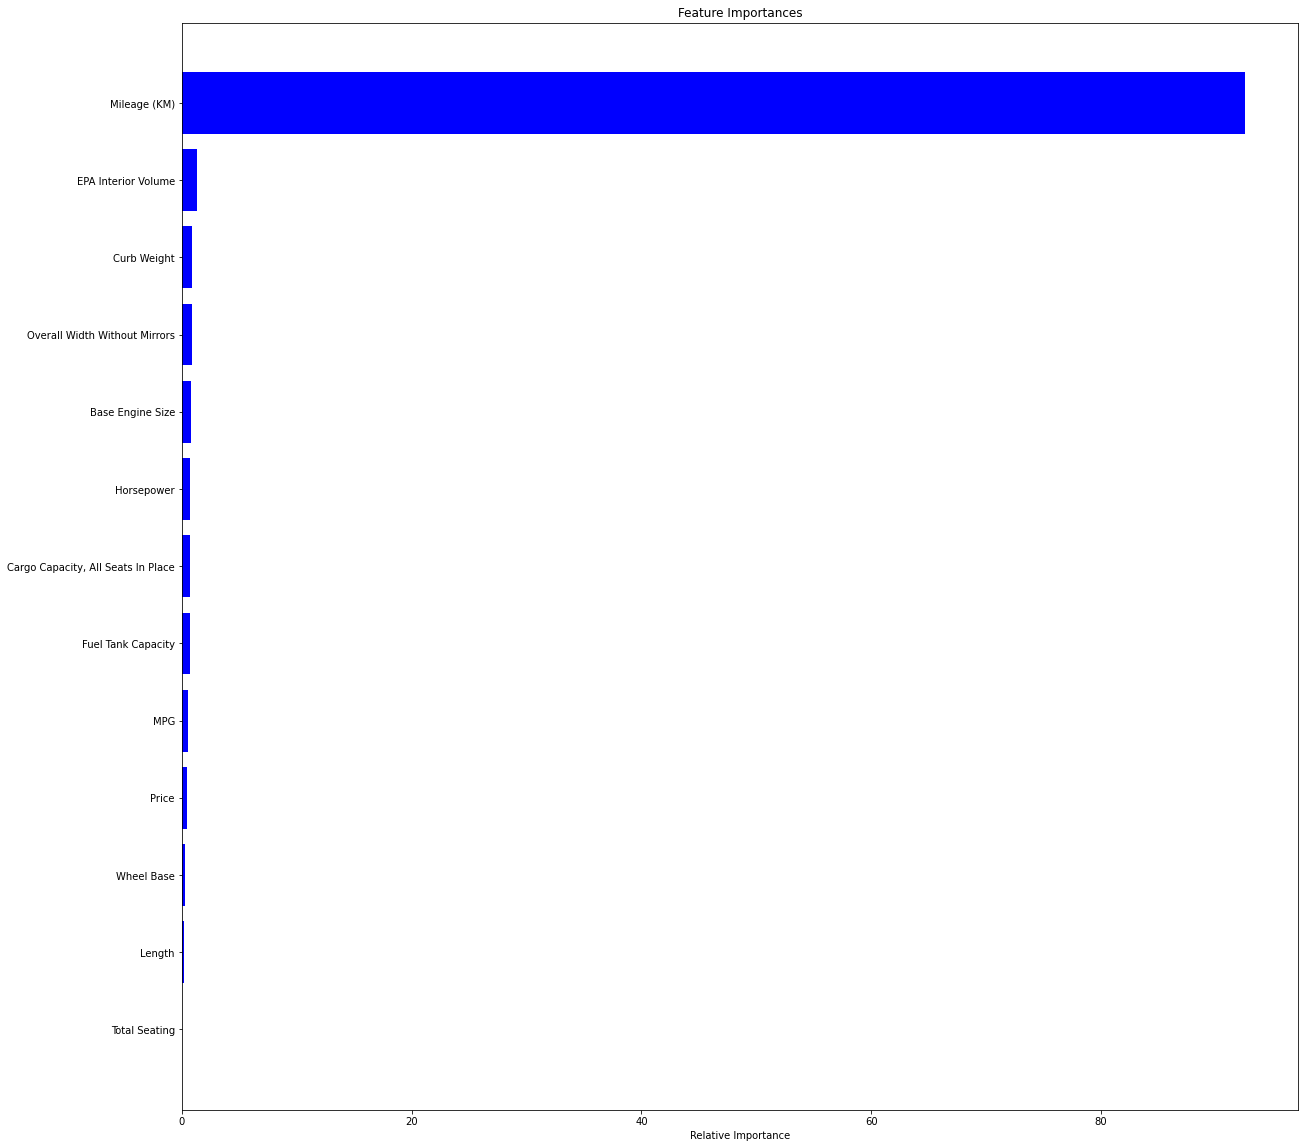

In [50]:
features = train.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=[20, 20])
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# A plot of the actual CO2 emission vs the predicted one.

**Test Data**

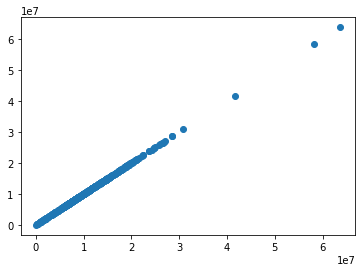

In [51]:
plt.scatter(x=y_test, y=y_test)

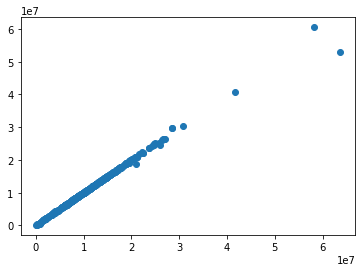

In [52]:
plt.scatter(x=y_test, y=predictions)

**Train Data**

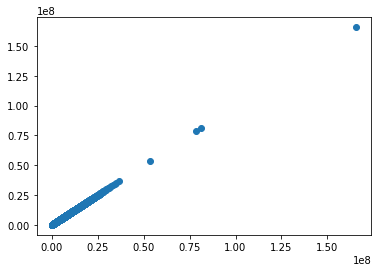

In [53]:
plt.scatter(x=y_train, y=y_train)

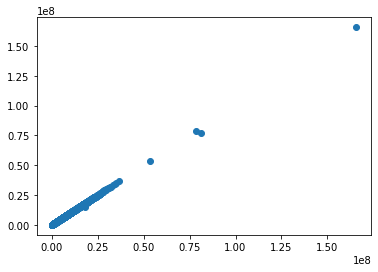

In [54]:
plt.scatter(x=y_train, y=model.predict(X_train))

# Histogram analysis of the prediction

**Test Data**

(array([ 96., 183., 115.,  31.,   9.,   0.,   1.,   0.,   0.,   2.]),
 array([7.90000000e+01, 6.36928530e+06, 1.27384916e+07, 1.91076979e+07,
        2.54769042e+07, 3.18461105e+07, 3.82153168e+07, 4.45845231e+07,
        5.09537294e+07, 5.73229357e+07, 6.36921420e+07]),
 <BarContainer object of 10 artists>)

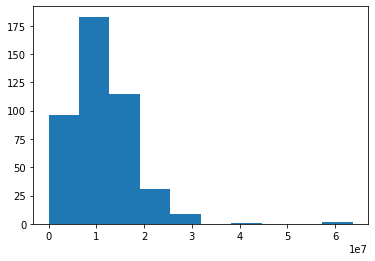

In [55]:
plt.hist(x=y_test)

(array([ 90., 174., 119.,  37.,  13.,   1.,   1.,   0.,   1.,   1.]),
 array([  148683.54348133,  6188651.69177551, 12228619.84006969,
        18268587.98836387, 24308556.13665805, 30348524.28495223,
        36388492.4332464 , 42428460.58154058, 48468428.72983477,
        54508396.87812895, 60548365.02642313]),
 <BarContainer object of 10 artists>)

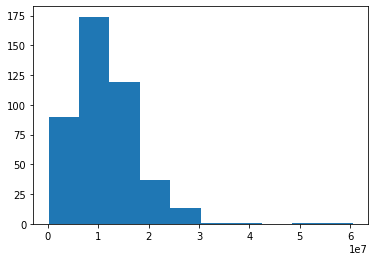

In [56]:
plt.hist(x=predictions)

**Train Data**

(array([1.05e+03, 2.51e+02, 4.00e+00, 1.00e+00, 2.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([8.10000000e+01, 1.65638856e+07, 3.31276902e+07, 4.96914948e+07,
        6.62552994e+07, 8.28191040e+07, 9.93829086e+07, 1.15946713e+08,
        1.32510518e+08, 1.49074322e+08, 1.65638127e+08]),
 <BarContainer object of 10 artists>)

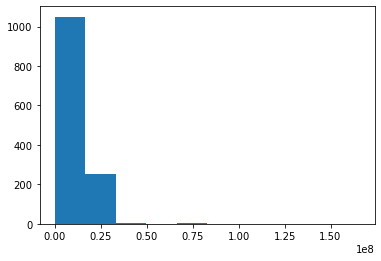

In [57]:
plt.hist(x=y_train)

(array([1.05e+03, 2.51e+02, 4.00e+00, 1.00e+00, 2.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([-1.97799118e+02,  1.65552588e+07,  3.31107154e+07,  4.96661721e+07,
         6.62216287e+07,  8.27770853e+07,  9.93325419e+07,  1.15887999e+08,
         1.32443455e+08,  1.48998912e+08,  1.65554368e+08]),
 <BarContainer object of 10 artists>)

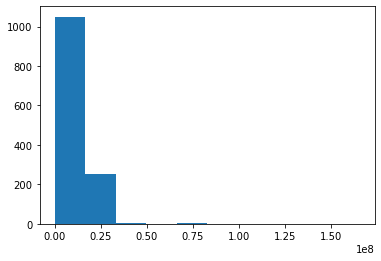

In [58]:
plt.hist(x=model.predict(X_train))